honnyaku
    https://tech.excite.co.jp/entry/2022/08/19/191151
    https://www.hamlet-engineer.com/posts/pdf_translate_02.html
    https://github.com/UKPLab/EasyNMT

dougigo chikan
    BERT no dataloader no toki ni yaru. maji no augmentation to issho
    ika, ichiou.
        https://engineering.mercari.com/blog/entry/20220210-eab9f5d823/
        https://qiita.com/tchih11/items/aef9505d26d1bf06a04c
        https://github.com/tchih11/qiita_eda/tree/main/notebooks
        DADA no lec-ai no CNN ga sankou ni naru.

# Hugging Face Library 'Transformer'およびT5Tokenizerのダウンロード

参考(https://qiita.com/takubb/items/fd972f0ac3dba909c293)これを基に改造し、最新のGoogle Colaboratoryで動作するようにした

In [1]:
!pip install transformers
!apt install swig
# Sentencepieceのインストール
!pip install sentencepiece
from transformers import T5Tokenizer
tokenizer = T5Tokenizer.from_pretrained("rinna/japanese-roberta-base")
tokenizer.do_lower_case = True  # due to some bug of tokenizer config loading

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


# PyTorchとGPU設定

In [2]:
!pip install torch
import torch
# GPUが使えれば利用する設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# データセットの準備

ライブドアニュースコーパスをダウンロード

    ダウンロードしたファイルは圧縮（tar.gz形式）ファイル
    様々なジャンル（IT,スポーツ,家電,映画など）のWEBメディアごとにフォルダに記事がテキストファイルで保存されている
    
以下、ファイルを読み込んで、必要な部分を抽出

In [3]:
import os
import re
import csv
import glob
import warnings
warnings.filterwarnings('ignore')
#urllib.request.urlretrieve("https://www.rondhuit.com/download/ldcc-20140209.tar.gz", "ldcc-20140209.tar.gz")
# ダウンロードした圧縮ファイルのパスを設定
#tgz_fname = "ldcc-20140209.tar.gz" 
# 2つをニュースメディアのジャンルを選定
mydata = '/export/livedoor' 
#処理をした結果を保存するファイル名 
tsv_fname = "all_text.tsv" 

def remove_brackets(inp):
    output = re.sub(u'[〃-〿]', '',(re.sub('＝|=|×|\(|\)|“|”|（|）|／|\[|\]| |　|…|・|\n|\t|/|＜|＞|@|＠', '', re.sub(u'[ℊ-⿻]', '', inp)))) #210A ~ 2FFF
    return output

"""
def read_url(f):
    url = next(f)
    return url[:-1]

def read_date(f):
    date = next(f)
    date = remove_brackets(date.encode().decode('utf-8'))
    return date[:-1]
"""

def read_title(f):
    next(f)
    next(f)
    title = next(f)
    title = remove_brackets(title.encode().decode('utf-8'))
    return title[:-1]

def read_para(f):
    p = ''
    while True:
        try:
            para = next(f)
            para = remove_brackets(para.encode().decode('utf-8'))
            p += para
        except StopIteration:
            break
    return p [:-1]

In [4]:
directory = ['/export/livedoor/dokujo-tsushin', '/export/livedoor/it-life-hack']
target_genre = ["dokujo-tsushin", "it-life-hack"] 
#directory = ['/export/livedoor/dokujo-tsushin', '/export/livedoor/peachy']
#target_genre = ["dokujo-tsushin", "peachy"] 
zero_fnames = []
one_fnames = []

if os.path.exists(tsv_fname) == True:
    with open(tsv_fname, "r+") as f:
        f.truncate(0)

for i in range(2):
    for filename in os.listdir(directory[i]):
        if "LICENSE.txt" in filename:
            continue
        f = os.path.join(directory[i], filename)
        #if os.path.isfile(f):
        #    print(f)
        if target_genre[0] in f and f.endswith(".txt"):
            with open(tsv_fname, "a") as wf:
                writer = csv.writer(wf, delimiter='\t')
                with open(f) as zf:
                    title = read_title(zf)
                    para = read_para(zf)
                    row = [target_genre[0], '0', title, para]
                    writer.writerow(row)
            continue
        if target_genre[1] in f and f.endswith(".txt"):
            with open(tsv_fname, "a") as wf:
                writer = csv.writer(wf, delimiter='\t')
                with open(f) as zf:
                    title = read_title(zf)
                    para = read_para(zf)
                    row = [target_genre[1], '1', title, para]
                    writer.writerow(row)
            continue

pandasでデータを読み込み

In [5]:
import pandas as pd
# データの読み込み
df = pd.read_csv("all_text.tsv", 
                 delimiter='\t', header=None, names=['media_name', 'label','title','sentence'])
# データの確認
print(f'データサイズ： {df.shape}')
df.sample(10)

データサイズ： (1740, 4)


,media_name,label,title,sentence
895,it-life-hack,1,ファイル整理に役立つ！カメラの情報表示知っ得！虎の,いくつものカメラを使用している場合、撮った写真をまとめてフォルダーに入れていると、いざ写真を...
578,dokujo-tsushin,0,女医が教えるオンナの体ウソホントvol.4イク！って何？Presentedbyゆるっとcaf,今回からドクター圭子の知らなきゃケガするオトナの医学が改題してパワーアップしているわよ。フフ...
100,dokujo-tsushin,0,オトナ女子映画部恋に恋する15歳の少女が見せる強い母性ヒミ,10代。特に15歳の時に戻れるならば、あなたは戻りたいと思うだろうか。仕事も無いし、悩みも少...
1092,it-life-hack,1,24時間しょこたん三昧本日0時より中川翔子が売ってみた！独り24時間テレビニコニコ生放送開,ドワンゴ及びニワンゴは、両社が運営する日本最大級の動画サービスniconicoのニコニコ生放...
522,dokujo-tsushin,0,オトナ女子映画部赤ん坊の父親に捨てられても、人生勝ち負けじゃないと断言する臨月妊婦ハラがコレなん,大丈夫！風向きが変わったら、その時、どーんといけばいいこの言葉は、ハラコレこと映画ハラがコレ...
606,dokujo-tsushin,0,ルールズが独女に与える影,気になる彼へ一生懸命に連絡をしている時には反応が薄いのに、こちらからのアクションをピタリと止...
777,dokujo-tsushin,0,自転車女子、はじめましたvol.01Presentedbyゆるっとcaf,自転車には興味はあれど、さてどうしようかとお悩みの独女の皆様。まったく興味はないけど、北条晶...
855,dokujo-tsushin,0,痩せたら本当に幸せなの？独女がダイエットを諦めたくなる,いよいよ夏到来！夏といえば薄着のシーズンとあって、時期的にもダイエットに一層関心が集まる頃だ...
1269,it-life-hack,1,ネットがなくても動画がスイスイ見られるスグレモノiPhoneでチャンスを掴,電波が届かなくてネットに接続できる環境ではないようなケースにあって、それでも動画を再生したい...
1147,it-life-hack,1,一風変わった動きが新鮮！ブロック系ゲームStar＊BurstiPhoneでチャンスを掴,いつまでかわからないけど時間をつぶしたいなんてときに向くのがこのちょっと変わった動きをするブ...


//文章データをsentences、ラベルデータを labelsに保存、以降この2変数だけを利用

In [6]:
mn = df.media_name.values
labels = df.label.values
titles = df.title.values
sentences = df.sentence.values

# Moji suu shitei

In [7]:
wcount = 128

'''
# wcount moji me kara kesu

for i in enumerate(sentences):
    if len(i[1])>wcount:
        sentences[i[0]] = sentences[i[0]][:wcount]

'''
# ushiro kara wcount moji toru

for i in enumerate(sentences):
    if len(i[1])>wcount:
        sentences[i[0]] = sentences[i[0]][-wcount:]
#'''

# Data Augmentation

同義語で置換, randomな同義語挿入, randomなワード移動, randomなワード削除, 逆翻訳


    bert no mask ni tango ireru yatsu mo ikesou
    
    https://qiita.com/tchih11/items/aef9505d26d1bf06a04c
    https://github.com/tchih11/qiita_eda
    
    atoha honnyaku desune

# BERT Tokenizerを用いて単語分割・IDへ変換
## Tokenizerの準備
単語分割とIDへ変換

# テスト実行

In [8]:
# 元文章
print(' Original: ', sentences[0])
# Tokenizer
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
# Token-id
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  霊的存在との対話からあなたのこれから迎える環境人間関係などの状況を見通します。nifty電話占いメール占いでは霊感鑑定はもちろん、タロットから運勢の流れを読み解き、また、夢分析から近未来を予測します。関連サイトnifty電話占いメール占い翔生先生プロフィー
Tokenized:  ['▁', '霊', '的存在', 'との', '対話', 'から', 'あなた', 'の', 'これから', '迎え', 'る', '環境', '人間関係', 'などの', '状況を', '見通し', 'ます', '。', 'ni', 'f', 'ty', '電話', '占い', 'メール', '占い', 'では', '霊', '感', '鑑定', 'はもちろん', '、', 'タ', 'ロット', 'から', '運', '勢', 'の流れ', 'を読み', '解き', '、', 'また', '、', '夢', '分析', 'から', '近', '未来', 'を', '予測', 'します', '。', '関連', 'サイト', 'ni', 'f', 'ty', '電話', '占い', 'メール', '占い', '翔', '生', '先生', 'プロ', 'フィー']
Token IDs:  [9, 1530, 14374, 271, 15700, 28, 5465, 10, 19518, 11926, 56, 778, 27138, 120, 13068, 19898, 3418, 8, 3570, 210, 5432, 2454, 21227, 3675, 21227, 38, 1530, 852, 14071, 17554, 7, 170, 11699, 28, 2680, 1436, 6995, 14215, 21070, 7, 240, 7, 1392, 2453, 28, 1518, 3638, 18, 6405, 18460, 8, 1617, 1487, 3570, 210, 5432, 2454, 21227, 3675, 21227, 8288, 196, 7016, 449, 3815]


In [9]:
# 最大単語数の確認
max_len = []
# 1文づつ処理
for sent in sentences:
    # Tokenizeで分割
    token_words = tokenizer.tokenize(sent)
    # 文章数を取得してリストへ格納
    max_len.append(len(token_words))
# 最大の値を確認
print('最大単語数: ', max(max_len))
print('上記の最大単語数にSpecial token（[CLS], [SEP]）の+2をした値が最大単語数')

最大単語数:  89
上記の最大単語数にSpecial token（[CLS], [SEP]）の+2をした値が最大単語数


In [10]:
input_ids = []
attention_masks = []

# 1文づつ処理
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, # Special Tokenの追加
                        max_length = wcount+2,  # I think maximum 文章の長さを固定（Padding/Trancatinating）
                        truncation=True,                
                        pad_to_max_length = True,# PADDINGで埋める
                        return_attention_mask = True,   # Attention maksの作成
                        return_tensors = 'pt',     #  Pytorch tensorsで返す
                   )
    
    # https://qiita.com/YuiKasuga/items/343309257da1798c1b63

    # 単語IDを取得    
    input_ids.append(encoded_dict['input_ids'])

    # Attention　maskの取得
    attention_masks.append(encoded_dict['attention_mask'])

# リストに入ったtensorを縦方向（dim=0）へ結合
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# tenosor型に変換
labels = torch.tensor(labels)

# 確認
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('attention masks: ', attention_masks[0])
print('labels: ', labels[0])

Original:  霊的存在との対話からあなたのこれから迎える環境人間関係などの状況を見通します。nifty電話占いメール占いでは霊感鑑定はもちろん、タロットから運勢の流れを読み解き、また、夢分析から近未来を予測します。関連サイトnifty電話占いメール占い翔生先生プロフィー
Token IDs: tensor([    9,  1530, 14374,   271, 15700,    28,  5465,    10, 19518, 11926,
           56,   778, 27138,   120, 13068, 19898,  3418,     8,  3570,   210,
         5432,  2454, 21227,  3675, 21227,    38,  1530,   852, 14071, 17554,
            7,   170, 11699,    28,  2680,  1436,  6995, 14215, 21070,     7,
          240,     7,  1392,  2453,    28,  1518,  3638,    18,  6405, 18460,
            8,  1617,  1487,  3570,   210,  5432,  2454, 21227,  3675, 21227,
         8288,   196,  7016,   449,  3815,     2,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3

In [11]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# データセットクラスの作成
dataset = TensorDataset(input_ids, attention_masks, labels)

# 90%地点のIDを取得
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# データセットを分割
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('訓練データ数：{}'.format(train_size))
print('検証データ数:　{} '.format(val_size))

# データローダーの作成
batch_size = 32

# 訓練データローダー
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # ランダムにデータを取得してバッチ化
            batch_size = batch_size
        )

# 検証データローダー
validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), # 順番にデータを取得してバッチ化
            batch_size = batch_size
        )

len(validation_dataloader)

訓練データ数：1566
検証データ数:　174 


6

In [12]:
len(next(iter(validation_dataloader))[2])

32

In [13]:
from transformers import BertForSequenceClassification,AdamW,BertConfig

# BertForSequenceClassification 学習済みモデルのロード
model = BertForSequenceClassification.from_pretrained(
    "cl-tohoku/bert-base-japanese-whole-word-masking", # 日本語Pre trainedモデルの指定
    num_labels = 2, # ラベル数（今回はBinayなので2、数値を増やせばマルチラベルも対応可）
    output_attentions = False, # アテンションベクトルを出力するか
    output_hidden_states = False, # 隠れ層を出力するか
)

# モデルをGPUへ転送
model.cuda()

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialize

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [14]:
# 最適化手法の設定
optimizer = AdamW(model.parameters(), lr=2e-5)

# 訓練パートの定義
def train(model):
    model.train() # 訓練モードで実行
    train_loss = 0
    for batch in train_dataloader:# train_dataloaderはword_id, mask, labelを出力する点に注意
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()
    return train_loss

# テストパートの定義
def validation(model):
    model.eval()# 訓練モードをオフ
    val_loss = 0
    with torch.no_grad(): # 勾配を計算しない
        for batch in validation_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            with torch.no_grad():        
                (loss, logits) = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
            val_loss += loss.item()
    return val_loss

In [15]:
# 学習の実行
max_epoch = 10
train_loss_ = []
test_loss_ = []

for epoch in range(max_epoch):
    train_ = train(model)
    test_ = train(model)
    train_loss_.append(train_)
    test_loss_.append(test_)

In [16]:
import statistics

#correct = 0
test_accuracy = []

# 検証方法の確認（1バッチ分で計算ロジックに確認）

model.eval()# 訓練モードをオフ
for batch in validation_dataloader:
    #print(batch)
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    #print(len(b_labels))
    with torch.no_grad():   
        # 学習済みモデルによる予測結果をpredsで取得     
        preds = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        
        test_accuracy.append((torch.argmax(preds[0], 1) == b_labels).sum().item() / len(b_labels))

        #print('preds: ', torch.argmax(preds[0], 1))
        #print('b_labels: ', b_labels)
'''
        if preds == b_labels:
            correct += 1
            #test_accuracy += torch.sum(preds == b_labels).item() / len(b_labels)

#test_accuracy = correct/len(b_labels)
print(correct)
'''
print(statistics.mean(test_accuracy))


0.9382440476190477


In [17]:
a = torch.randn(4, 4)
print(a)
print(torch.argmax(a))

tensor([[-0.6981, -0.4038, -3.1329,  0.4686],
        [ 0.5648,  1.1663,  0.8796, -0.7696],
        [ 0.0317, -2.3665, -1.1063,  1.3619],
        [-0.5401, -1.6042,  0.2561, -0.9582]])
tensor(11)


In [18]:
# 予測結果の確認
print(f'出力:{preds}')

出力:SequenceClassifierOutput(loss=None, logits=tensor([[ 0.7258, -0.7380],
        [ 5.6684, -5.2296],
        [-5.6058,  5.1628],
        [-5.4924,  5.2128],
        [ 5.6893, -5.2658],
        [-5.5043,  5.1518],
        [ 5.6441, -5.2674],
        [-5.3270,  4.9042],
        [-5.5250,  5.1797],
        [ 5.6396, -5.2601],
        [ 5.7226, -5.2505],
        [-5.5828,  5.1828],
        [ 0.9430, -0.5578],
        [ 0.9628, -0.9982]], device='cuda:0'), hidden_states=None, attentions=None)


In [19]:
# 比較しやすい様にpd.dataframeへ整形
import numpy as np
# pd.dataframeへ変換（GPUに乗っているTensorはgpu->cpu->numpy->dataframeと変換）
logits_df = pd.DataFrame(preds[0].cpu().numpy(), columns=['logit_0', 'logit_1'])
## np.argmaxで大き方の値を取得
pred_df = pd.DataFrame(np.argmax(preds[0].cpu().numpy(), axis=1), columns=['pred_label'])
label_df = pd.DataFrame(b_labels.cpu().numpy(), columns=['true_label'])
accuracy_df = pd.concat([logits_df, pred_df, label_df], axis=1)
accuracy_df.head()

,logit_0,logit_1,pred_label,true_label
0,0.725792,-0.738010,0,1
1,5.668363,-5.229561,0,0
2,-5.605815,5.162815,1,1
3,-5.492358,5.212778,1,1
4,5.689305,-5.265842,0,0


In [20]:
'''
correct = 0
test_accuracy = 0

p_list = []
l_list = []

p_list = pred_df.values.tolist()
l_list = label_df.values.tolist()

#print(type(pred_df))

for i in range(len(b_labels)):
    if(p_list[i] == l_list[i]):
        correct += 1

test_accuracy = correct/len(b_labels)

print(test_accuracy)
'''

'\ncorrect = 0\ntest_accuracy = 0\n\np_list = []\nl_list = []\n\np_list = pred_df.values.tolist()\nl_list = label_df.values.tolist()\n\n#print(type(pred_df))\n\nfor i in range(len(b_labels)):\n    if(p_list[i] == l_list[i]):\n        correct += 1\n\ntest_accuracy = correct/len(b_labels)\n\nprint(test_accuracy)\n'

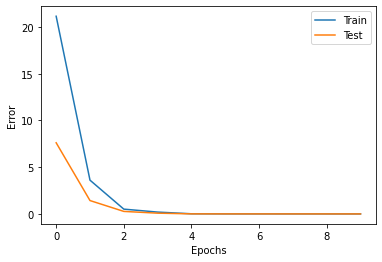

In [21]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_loss_)), train_loss_, label="Train")
plt.plot(range(len(test_loss_)), test_loss_, label="Test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()  # ラベルがあるときは、きちんとplt.show()を呼び出すこと

In [22]:
f

'/export/livedoor/it-life-hack/it-life-hack-6331762.txt'